In [58]:
import numpy as np
import tensorflow as tf
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import StandardScaler
from node.core import get_node_function
from node.solvers import RK4Solver
from node.hopfield import hopfield, identity, rescale


# for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


def process(X, y):
    X = X / 255.
    X = np.reshape(X, [-1, 28 * 28])
    y = np.eye(10)[y]
    return X.astype('float32'), y.astype('float32')


mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = process(x_train, y_train)
x_test, y_test = process(x_test, y_test)

scalar = StandardScaler()
scalar.fit(x_train)
x_train = scalar.transform(x_train)
x_test = scalar.transform(x_test)

In [2]:
tf.keras.backend.clear_session()

base_model = tf.keras.Sequential([
    tf.keras.layers.Input([28 * 28]),
    tf.keras.layers.Dense(64, use_bias=False),  # down-sampling
    tf.keras.layers.Dense(10, activation='softmax')
])

base_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Nadam(1e-3),
    metrics=['accuracy'])

callbacks = []
logdir = 'logs/base'
# logdir = None
if logdir:
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir=logdir, histogram_freq=1, write_images=True, update_freq=10)
    callbacks.append(tensorboard)

base_model.fit(x_train, y_train, epochs=10, batch_size=128, callbacks=callbacks)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 41us/sample - loss: 0.4483 - accuracy: 0.8815
Epoch 2/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.3178 - accuracy: 0.9155
Epoch 3/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.2941 - accuracy: 0.9198
Epoch 4/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.2852 - accuracy: 0.9218
Epoch 5/10
60000/60000 [==============================] - 1s 25us/sample - loss: 0.2772 - accuracy: 0.9245
Epoch 6/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.2729 - accuracy: 0.9259
Epoch 7/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.2689 - accuracy: 0.9267
Epoch 8/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.2650 - accuracy: 0.9266
Epoch 9/10
60000/60000 [==============================] - 3s 56us/sample - loss: 0.2640 - accuracy: 0.9284
Epoch 10/10
60

In [3]:
class NonHopfieldLayer(tf.keras.layers.Layer):

    def __init__(self, units, dt, num_grids, **kwargs):
        super().__init__(**kwargs)
        self.dt = dt
        self.num_grids = num_grids

        t0 = tf.constant(0.)
        self.tN = t0 + num_grids * dt

        self._model = tf.keras.Sequential([
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dense(units),
        ])
        self._model.build([None, units])
        self._pvf = lambda _, x: self._model(x)

        solver = RK4Solver(self.dt)
        self._node_fn = get_node_function(solver, tf.constant(0.), self._pvf)

    def call(self, x):
        return self._node_fn(self.tN, x)

    def get_config(self):
        return super().get_config().copy()


def get_trained_non_hopfield_model(logdir=None, epochs=10, lr=1e-3, epsilon=1e-2):
    tf.keras.backend.clear_session()

    non_hopfield_model = tf.keras.Sequential([
        tf.keras.layers.Input([28 * 28]),
        tf.keras.layers.Dense(64, use_bias=False),  # down-sampling
        NonHopfieldLayer(64, dt=1e-1, num_grids=10),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    non_hopfield_model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.optimizers.Nadam(lr, epsilon=epsilon),
        metrics=['accuracy'])

    callbacks = []
    if logdir:
        tensorboard = tf.keras.callbacks.TensorBoard(
            log_dir=logdir, histogram_freq=1, write_images=True, update_freq=10)
        callbacks.append(tensorboard)

    non_hopfield_model.fit(x_train, y_train, epochs=epochs, batch_size=128, callbacks=callbacks)
    return non_hopfield_model

In [4]:
non_hopfield_model = get_trained_non_hopfield_model(logdir='logs/non_hopfield')

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.3773 - accuracy: 0.8953
Epoch 2/10
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.1669 - accuracy: 0.9519
Epoch 3/10
60000/60000 [==============================] - 59s 991us/sample - loss: 0.1154 - accuracy: 0.9658
Epoch 4/10
60000/60000 [==============================] - 52s 875us/sample - loss: 0.0935 - accuracy: 0.9729
Epoch 5/10
60000/60000 [==============================] - 50s 833us/sample - loss: 0.0755 - accuracy: 0.9778
Epoch 6/10
60000/60000 [==============================] - 50s 829us/sample - loss: 0.0599 - accuracy: 0.9819
Epoch 7/10
60000/60000 [==============================] - 50s 828us/sample - loss: 0.0489 - accuracy: 0.9848
Epoch 8/10
60000/60000 [==============================] - 52s 868us/sample - loss: 0.0411 - accuracy: 0.9869
Epoch 9/10
60000/60000 [==============================] - 52s 867us/sample - loss: 0.0345 - accuracy: 0.9893


In [13]:
longer_trajectory_non_hopfield_model = tf.keras.Sequential([
    tf.keras.layers.Input([28 * 28]),
    tf.keras.layers.Dense(64, use_bias=False),  # down-sampling
    NonHopfieldLayer(64, dt=1e-1, num_grids=30),
    tf.keras.layers.Dense(10, activation='softmax')
])

longer_trajectory_non_hopfield_model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'])

longer_trajectory_non_hopfield_model.set_weights(non_hopfield_model.get_weights())
longer_trajectory_non_hopfield_model.evaluate(x_train, y_train, batch_size=128)

60000/60000 [==============================] - 29s 481us/sample - loss: 2.1252 - accuracy: 0.8300


[2.125220081456502, 0.83003336]

In [64]:
class HopfieldLayer(tf.keras.layers.Layer):

    def __init__(self, units, dt, num_grids,
                 lower_bounded_fn=lambda x: tf.reduce_sum(tf.square(x)),
                 linear_transform=identity,
                 **kwargs):
        super().__init__(**kwargs)
        self.dt = dt
        self.num_grids = num_grids
        self.lower_bounded_fn = lower_bounded_fn
        self.linear_transform = linear_transform

        t0 = tf.constant(0.)
        self.tN = t0 + num_grids * dt

        self._model = tf.keras.Sequential([
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dense(units),
        ])
        self._model.build([None, units])
        self._pvf = hopfield(self.linear_transform,
                             lambda x: self.lower_bounded_fn(self._model(x)))
        solver = RK4Solver(self.dt)
        self._node_fn = get_node_function(
            solver, tf.constant(0.), self._pvf)

    def call(self, x):
        y = self._node_fn(self.tN, x)
        return y

    def get_config(self):
        return super().get_config().copy()


def get_trained_hopfield_model(lower_bounded_fn, linear_transform=identity, logdir=None, epochs=10, lr=1e-3, epsilon=1e-2):
    tf.keras.backend.clear_session()

    hopfield_model = tf.keras.Sequential([
        tf.keras.layers.Input([28 * 28]),
        tf.keras.layers.Dense(64, use_bias=False),  # down-sampling
        HopfieldLayer(64, dt=1e-1, num_grids=10,
                      linear_transform=linear_transform,
                      lower_bounded_fn=lower_bounded_fn),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    hopfield_model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.optimizers.Nadam(lr, epsilon=epsilon),
        metrics=['accuracy'])

    callbacks = []
    if logdir is not None:
        tensorboard = tf.keras.callbacks.TensorBoard(
            log_dir=logdir, histogram_freq=1, write_images=True, update_freq=10)
        callbacks.append(tensorboard)
    hopfield_model.fit(x_train, y_train, epochs=epochs, batch_size=128, callbacks=callbacks)
    return hopfield_model

In [65]:
@tf.function
def lower_bounded_fn(x):
    return tf.reduce_sum(tf.square(x), axis=1)

hopfield_model = get_trained_hopfield_model(lower_bounded_fn, logdir='logs/hopfield', lr=1e-2)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 117s 2ms/sample - loss: 0.4491 - accuracy: 0.8742
Epoch 2/10
60000/60000 [==============================] - 145s 2ms/sample - loss: 0.2584 - accuracy: 0.9259
Epoch 3/10
33024/60000 [===============>..............] - ETA: 1:25 - loss: 0.2118 - accuracy: 0.9388

KeyboardInterrupt: 

In [12]:
longer_trajectory_hopfield_model = tf.keras.Sequential([
    tf.keras.layers.Input([28 * 28]),
    tf.keras.layers.Dense(64, use_bias=False),  # down-sampling
    HopfieldLayer(64, dt=1e-1, num_grids=30),
    tf.keras.layers.Dense(10, activation='softmax')
])

longer_trajectory_hopfield_model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'])

longer_trajectory_hopfield_model.set_weights(hopfield_model.get_weights())
longer_trajectory_hopfield_model.evaluate(x_train, y_train, batch_size=128)

60000/60000 [==============================] - 69s 1ms/sample - loss: 0.0298 - accuracy: 0.9920


[0.02980655856480201, 0.99205]

In [66]:
@tf.function
def lower_bounded_fn(x):
    return tf.reduce_mean(tf.square(x))

hopfield_variation = get_trained_hopfield_model(lower_bounded_fn, lr=1e-2)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 175s 3ms/sample - loss: 0.4766 - accuracy: 0.8686
Epoch 2/10
60000/60000 [==============================] - 179s 3ms/sample - loss: 0.3208 - accuracy: 0.9113
Epoch 3/10
60000/60000 [==============================] - 139s 2ms/sample - loss: 0.2975 - accuracy: 0.9171
Epoch 4/10
60000/60000 [==============================] - 138s 2ms/sample - loss: 0.2863 - accuracy: 0.9206
Epoch 5/10
 8320/60000 [===>..........................] - ETA: 2:06 - loss: 0.2802 - accuracy: 0.9213

KeyboardInterrupt: 

In [ ]:
@tf.function
def lower_bounded_fn(x):
    return tf.reduce_sum(tf.nn.softplus(x))

hopfield_variation_1 = get_trained_hopfield_model(lower_bounded_fn)

In [ ]:
@tf.function
def lower_bounded_fn(x):
    return tf.nn.softplus(tf.reduce_sum(x))

hopfield_variation_2 = get_trained_hopfield_model(lower_bounded_fn)

In [ ]:
@tf.function
def lower_bounded_fn(x):
    return tf.reduce_sum(tf.abs(x))

hopfield_variation_3 = get_trained_hopfield_model(lower_bounded_fn)

In [ ]:
@tf.function
def lower_bounded_fn(x):
    return tf.abs(tf.reduce_sum(x))

hopfield_variation_4 = get_trained_hopfield_model(lower_bounded_fn)

### Conclusion

It is found that $\mathcal{E}(x) = \sum_{\alpha} x_{\alpha}^2$ performs elegently. Howerver, other $\mathcal{E}$, like $\sum_{\alpha} \sigma(x_{\alpha})$, $\sum_{\alpha} |x_{\alpha}|$, etc, won't get enough performance.

Now, we investigate why it is so.

In [34]:
non_hopfield_model_test = get_trained_non_hopfield_model(epochs=2)

Train on 60000 samples
Epoch 1/2
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.3731 - accuracy: 0.8969
Epoch 2/2
60000/60000 [==============================] - 59s 977us/sample - loss: 0.1705 - accuracy: 0.9513


In [41]:
@tf.function
def lower_bounded_fn(x):
    return tf.reduce_sum(tf.square(x), axis=1)

hopfield_model_test = get_trained_hopfield_model(lower_bounded_fn, epochs=2)

Train on 60000 samples
Epoch 1/2
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.3973 - accuracy: 0.8882
Epoch 2/2
60000/60000 [==============================] - 210s 4ms/sample - loss: 0.1832 - accuracy: 0.9470


In [ ]:
@tf.function
def lower_bounded_fn(x):
    return tf.reduce_mean(tf.square(x))

hopfield_model_1_test = get_trained_hopfield_model(lower_bounded_fn, epochs=2)

In [ ]:
@tf.function
def lower_bounded_fn(x):
    return tf.reduce_sum(tf.sigmoid(x))

hopfield_model_2_test = get_trained_hopfield_model(lower_bounded_fn, epochs=2)

In [ ]:
@tf.function
def lower_bounded_fn(x):
    return tf.reduce_sum(tf.abs(x))

hopfield_model_3_test = get_trained_hopfield_model(lower_bounded_fn, epochs=2)

In [ ]:
@tf.function
def lower_bounded_fn(x):
    return tf.reduce_sum(4 * tf.square(x))

hopfield_model_4_test = get_trained_hopfield_model(lower_bounded_fn, epochs=2)

In [ ]:
@tf.function
def lower_bounded_fn(x):
    return tf.reduce_sum(5 * tf.abs(x))

hopfield_model_5_test = get_trained_hopfield_model(lower_bounded_fn, epochs=2)

In [40]:
lower_bounded_fn = tf.keras.layers.Dense(
    1, activation=tf.square, use_bias=False,
#     kernel_initializer=tf.initializers.RandomUniform(minval=-1., maxval=1.),
)

hopfield_model_6_test = get_trained_hopfield_model(lower_bounded_fn, epochs=2)

Train on 60000 samples
Epoch 1/2
60000/60000 [==============================] - 146s 2ms/sample - loss: 0.4712 - accuracy: 0.8719
Epoch 2/2
60000/60000 [==============================] - 148s 2ms/sample - loss: 0.2626 - accuracy: 0.9280


In [21]:
from collections import namedtuple
from node.core import reverse_mode_derivative
from node.utils.trajectory import tracer
from node.solvers import RK4Solver


def reverse(xs):
    return list(reversed(xs))


InvTraces = namedtuple('InvTraces', 'z, loss_grad_z, loss_grad_vars, pvf, f')


def get_inv_traces(node_model, x, y, num_grids, t0=tf.constant(0.), t1=tf.constant(1.)):
    layers = node_model.layers
    node_layer = layers[1]
    node_vars = node_layer.trainable_variables

    # compute final_loss_grad
    with tf.GradientTape() as g:
        final_z = layers[1](layers[0](x))
        g.watch(final_z)
        y_pred = layers[2](final_z)
        loss = tf.losses.categorical_crossentropy(y, y_pred)
    final_loss_grad_z, final_loss_grad_vars = g.gradient(loss, [final_z, node_vars])

    solver = RK4Solver(0.1)
    pvf = node_layer._pvf
    f = node_layer._model
    backward = reverse_mode_derivative(solver, pvf, node_vars)

    z_trace = [final_z]
    loss_grad_z_trace = [final_loss_grad_z]
    loss_grad_vars_trace = [final_loss_grad_vars]
    pvf_trace = [pvf(tf.constant(1.), final_z)]
    f_trace = [f(final_z)]

    dt = (t1 - t0) / num_grids
    for i in range(num_grids):
        t_start = t1 - (i + 1) * dt
        z, loss_grad_z, loss_grad_vars = backward(t_start, t1, final_z, final_loss_grad_z)        
        z_trace.append(z)
        loss_grad_z_trace.append(loss_grad_z)
        loss_grad_vars_trace.append(loss_grad_vars)
        pvf_trace.append(pvf(t_start, z))
        f_trace.append(f(z))

    loss_grad_vars_trace_ = [[] for _ in loss_grad_vars_trace[0]]
    for loss_grad_vars in loss_grad_vars_trace:
        for i, loss_grad_var in enumerate(loss_grad_vars):
            loss_grad_vars_trace_[i].append(loss_grad_var)
    loss_grad_vars_trace = loss_grad_vars_trace_

    return InvTraces(z_trace, loss_grad_z_trace, loss_grad_vars_trace, pvf_trace, f_trace)

In [48]:
x_ = tf.constant(x_train[:128])
y_ = tf.constant(y_train[:128])
num_grids = 10
non_hopfield_inv_traces = get_inv_traces(non_hopfield_model_test, x_, y_, num_grids)
hopfield_inv_traces = get_inv_traces(hopfield_model_test, x_, y_, num_grids)
hopfield_variant_inv_traces = get_inv_traces(hopfield_model_6_test, x_, y_, num_grids)

In [49]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def compare_hist(*traces, **kwargs):
    labels = kwargs.pop('labels', None)
    title = kwargs.pop('title', None)
    
    def flatten(tensor_or_tensors):
        if isinstance(tensor_or_tensors, list):
            array = np.array([t.numpy().tolist() for t in tensor_or_tensors])
        else:
            array = np.array(tensor_or_tensors)
        return array.reshape([-1])

    fig = plt.figure()

    def update_hist(step, traces):
        plt.cla()
        for i, trace in enumerate(traces):
            if labels:
                label = labels[i]
            else:
                label = f'model_{i}'
            plt.hist(flatten(trace[step]), label=label, **kwargs)
        if title:
            plt.title(title)
        plt.legend()

    frames = len(traces[0])
    animation = FuncAnimation(fig, update_hist, frames, fargs=(traces, ) )
    return animation

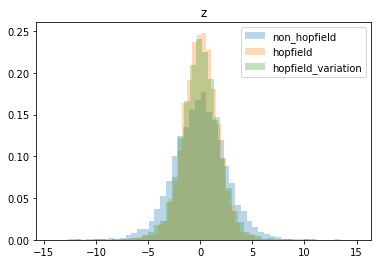

In [50]:
anim = compare_hist(
    non_hopfield_inv_traces.z,
    hopfield_inv_traces.z,
    hopfield_variant_inv_traces.z,
    bins=50, alpha=0.3, title='z',
    labels=[
        'non_hopfield',
        'hopfield',
        'hopfield_variation',
    ],
    density=True,
)
HTML(anim.to_jshtml())

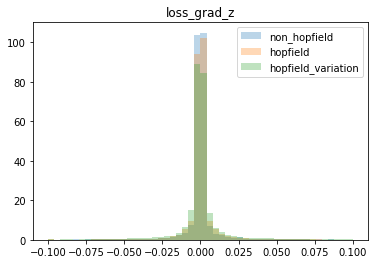

In [51]:
anim = compare_hist(
    non_hopfield_inv_traces.loss_grad_z,
    hopfield_inv_traces.loss_grad_z,
    hopfield_variant_inv_traces.loss_grad_z,
    bins=50, alpha=0.3, title=f'loss_grad_z',
    labels=[
        'non_hopfield',
        'hopfield',
        'hopfield_variation',
    ],
    density=True,
    range=(-0.1, 0.1),
)
HTML(anim.to_jshtml())

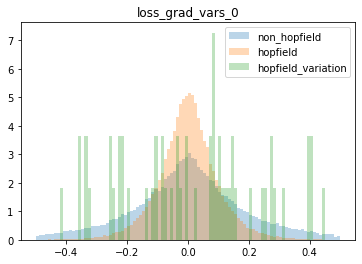

In [60]:
j = 0
anim = compare_hist(
    non_hopfield_inv_traces.loss_grad_vars[j],
    hopfield_inv_traces.loss_grad_vars[j],
    hopfield_variant_inv_traces.loss_grad_vars[j],
    bins=100, alpha=0.3, title=f'loss_grad_vars_{j}',
    labels=[
        'non_hopfield',
        'hopfield',
        'hopfield_variation',
    ],
    density=True,
    range=(-0.5, 0.5),
)
HTML(anim.to_jshtml())

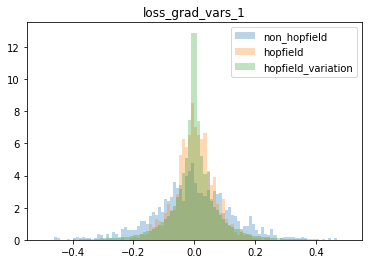

In [53]:
j = 1
anim = compare_hist(
    non_hopfield_inv_traces.loss_grad_vars[j],
    hopfield_inv_traces.loss_grad_vars[j],
    hopfield_variant_inv_traces.loss_grad_vars[j],
    bins=100, alpha=0.3, title=f'loss_grad_vars_{j}',
    labels=[
        'non_hopfield',
        'hopfield',
        'hopfield_variation',
    ],
    density=True,
    range=(-0.5, 0.5),
)
HTML(anim.to_jshtml())

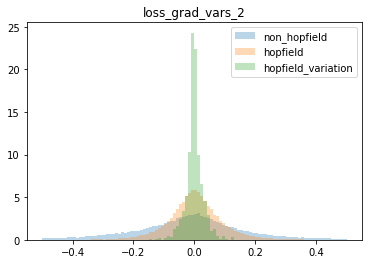

In [54]:
j = 2
anim = compare_hist(
    non_hopfield_inv_traces.loss_grad_vars[j],
    hopfield_inv_traces.loss_grad_vars[j],
    hopfield_variant_inv_traces.loss_grad_vars[j],
    bins=100, alpha=0.3, title=f'loss_grad_vars_{j}',
    labels=[
        'non_hopfield',
        'hopfield',
        'hopfield_variation',
    ],
    density=True,
    range=(-0.5, 0.5),
)
HTML(anim.to_jshtml())

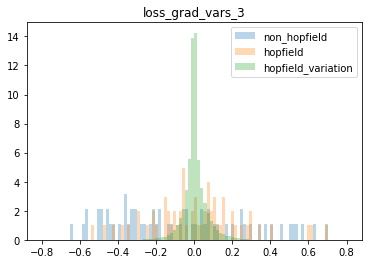

In [55]:
j = 3
anim = compare_hist(
    non_hopfield_inv_traces.loss_grad_vars[j],
    hopfield_inv_traces.loss_grad_vars[j],
    hopfield_variant_inv_traces.loss_grad_vars[j],
    bins=100, alpha=0.3, title=f'loss_grad_vars_{j}',
    labels=[
        'non_hopfield',
        'hopfield',
        'hopfield_variation',
    ],
    density=True,
    range=(-0.8, 0.8),
)
HTML(anim.to_jshtml())

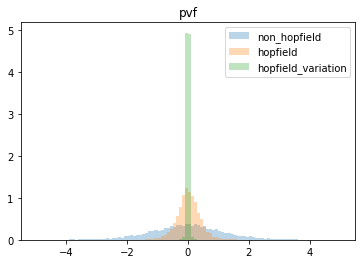

In [56]:
anim = compare_hist(
    non_hopfield_inv_traces.pvf,
    hopfield_inv_traces.pvf,
    hopfield_variant_inv_traces.pvf,
    bins=100, alpha=0.3, title=f'pvf',
    labels=[
        'non_hopfield',
        'hopfield',
        'hopfield_variation',
    ],
    density=True,
    range=(-5, 5),
)
HTML(anim.to_jshtml())

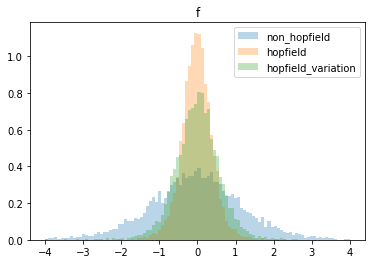

In [57]:
anim = compare_hist(
    non_hopfield_inv_traces.f,
    hopfield_inv_traces.f,
    hopfield_variant_inv_traces.f,
    bins=100, alpha=0.3, title='f',
    labels=[
        'non_hopfield',
        'hopfield',
        'hopfield_variation',
    ],
    density=True,
    range=(-4, 4),
)
HTML(anim.to_jshtml())

It is found that, it maybe the scale of pvf that determines the training effect. After training several variations, the $\mathcal{E} = \sum_{\alpha} x_{\alpha}^2$ performs best. Even with a simple rescaling, like $\mathcal{E} = 5 \sum_{\alpha} x_{\alpha}^2$, causes numerical instability.